In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

import acquire as ac
import prepare as pr

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = ac.get_telco_data()
train, validate, test = pr.prep_telco(df)
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (4218, 21)
validate shape = (1407, 20)
    test shape = (1407, 20)


In [10]:
train.head(50)

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,No,Multiple lines,Partner,TV and movies,Security and backup,6.0
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,No,Single line,Single,Movies,Backup,2.0
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,No,Single line,Partner and dependents,No internet service,No internet service,0.0
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,No,Single line,Partner,None,Security and backup,4.0
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,No,Single line,Partner,TV,Security,1.0
3997,2259-OUUSZ,Male,0,7,1,DSL,Yes,Yes,2,One year,Yes,4,Credit card (automatic),35.50,249.55,No,None,Single,None,None,1.0
6179,5161-XEUVX,Male,0,37,2,Fiber optic,Yes,Yes,3,Two year,No,2,Mailed check,94.30,3460.95,No,Multiple lines,Partner,TV,None,3.0
4570,2272-JKMSI,Female,0,62,2,Fiber optic,Yes,Yes,2,One year,Yes,1,Electronic check,110.80,6840.95,No,Multiple lines,Partner and dependents,TV and movies,Backup,5.0
3389,0871-OPBXW,Female,0,2,3,None,No internet service,No internet service,1,Month-to-month,Yes,2,Mailed check,20.05,39.25,No,Single line,Single,No internet service,No internet service,0.0
36,0374-AACSZ,Female,0,1,1,DSL,No,No,1,Month-to-month,No,1,Electronic check,50.15,50.15,No,Single line,Single,None,Security,0.0


---
# Explore

### If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

$H_0$: There is no difference in churn rate when accounting for tenure

$H_a$: There is a difference in churn rate when accounting for tenure

> Let's calculate churn rate

In [38]:
monthly = pd.DataFrame({
    "tenure": np.sort(train.tenure.unique()),
})

monthly["churn_rate"] = [((train.churn == "Yes") & (train.tenure == n)).sum() / (train.tenure == n).sum() for n in monthly.tenure]

monthly

,tenure,churn_rate
0,1,0.611860
1,2,0.492857
2,3,0.483871
3,4,0.448598
4,5,0.481013
...,...,...
67,68,0.109091
68,69,0.137931
69,70,0.085714
70,71,0.041667


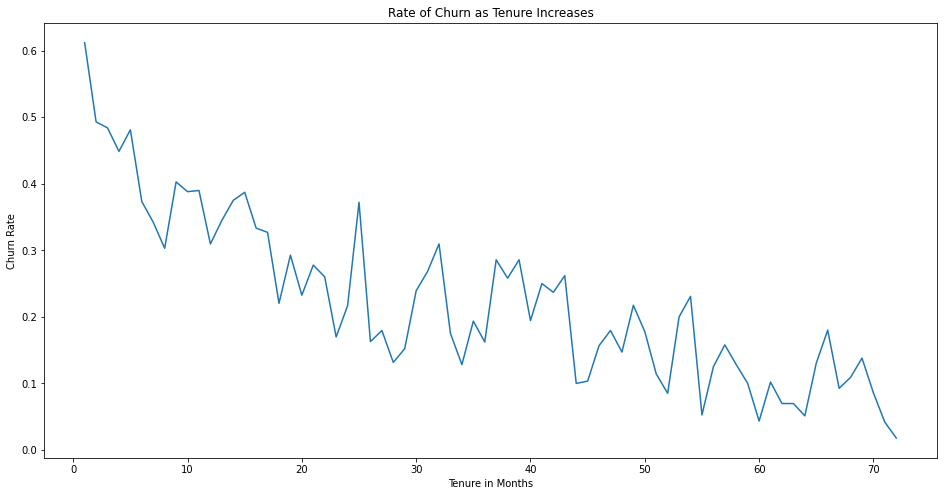

In [39]:
plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(monthly.tenure, monthly.churn_rate)
plt.xlabel("Tenure in Months")
plt.ylabel("Churn Rate")
plt.show()

In [44]:
yearly = pd.DataFrame({
    "tenure": np.sort(train.tenure_years.unique()),
})

yearly["churn_rate"] = [((train.churn == "Yes") & (train.tenure_years == n)).sum() / (train.tenure_years == n).sum() for n in yearly.tenure]

yearly

,tenure,churn_rate
0,0.0,0.525901
1,1.0,0.354136
2,2.0,0.222781
3,3.0,0.226457
4,4.0,0.172816
5,5.0,0.094340
6,6.0,0.069307


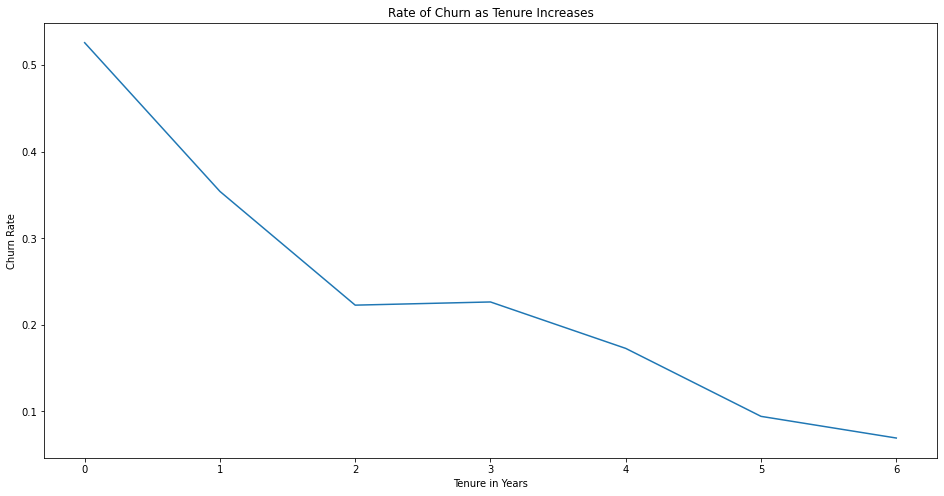

In [45]:
plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(yearly.tenure, yearly.churn_rate)
plt.xlabel("Tenure in Years")
plt.ylabel("Churn Rate")
plt.show()

In [55]:
train["tenure_years_binned"] = pd.cut(train.tenure_years, bins=3, labels=["0 to 2 years", "3 to 4 years", "5 to 6 years"])
train.head()

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years,tenure_years_binned
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,No,Multiple lines,Partner,TV and movies,Security and backup,6.0,5 to 6 years
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,No,Single line,Single,Movies,Backup,2.0,0 to 2 years
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,No,Single line,Partner and dependents,No internet service,No internet service,0.0,0 to 2 years
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,No,Single line,Partner,None,Security and backup,4.0,3 to 4 years
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,No,Single line,Partner,TV,Security,1.0,0 to 2 years


In [56]:
binned = pd.DataFrame({
    "tenure": np.sort(train.tenure_years_binned.unique()),
})

binned["churn_rate"] = [((train.churn == "Yes") & (train.tenure_years_binned == b)).sum() / (train.tenure_years_binned == b).sum() for b in binned.tenure]

binned

,tenure,churn_rate
0,0 to 2 years,0.388224
1,3 to 4 years,0.197711
2,5 to 6 years,0.080332


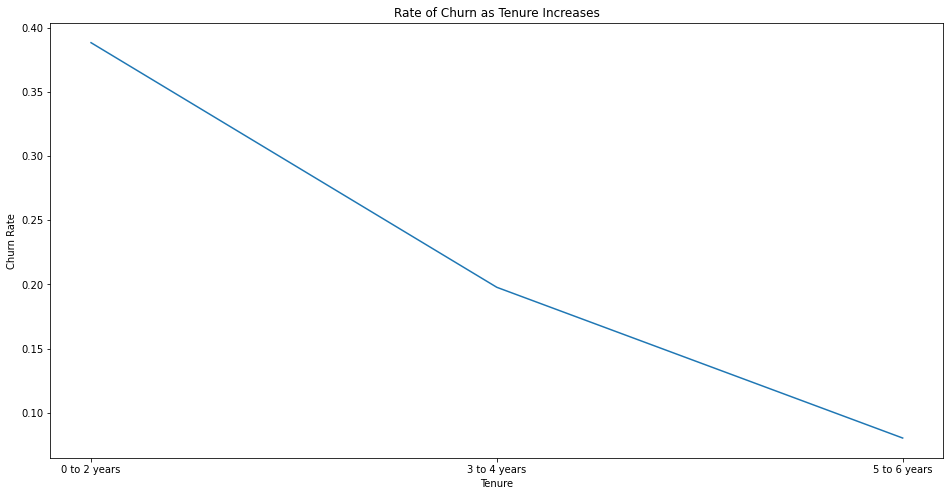

In [57]:
plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(binned.tenure, binned.churn_rate)
plt.xlabel("Tenure")
plt.ylabel("Churn Rate")
plt.show()

In [15]:
monthly_churn_rate = [((train.churn == "Yes") & (train.tenure == n)).sum() / (train.tenure == n).sum() for n in np.sort(train.tenure.unique())]
monthly_churn_rate

[0.6118598382749326,
 0.4928571428571429,
 0.4838709677419355,
 0.4485981308411215,
 0.4810126582278481,
 0.373134328358209,
 0.34210526315789475,
 0.30303030303030304,
 0.4027777777777778,
 0.3880597014925373,
 0.3898305084745763,
 0.30952380952380953,
 0.3448275862068966,
 0.375,
 0.3870967741935484,
 0.3333333333333333,
 0.3269230769230769,
 0.22033898305084745,
 0.2926829268292683,
 0.23255813953488372,
 0.2777777777777778,
 0.26,
 0.16981132075471697,
 0.21666666666666667,
 0.37209302325581395,
 0.16279069767441862,
 0.1794871794871795,
 0.13157894736842105,
 0.15217391304347827,
 0.2391304347826087,
 0.2682926829268293,
 0.30952380952380953,
 0.175,
 0.1282051282051282,
 0.1935483870967742,
 0.16216216216216217,
 0.2857142857142857,
 0.25806451612903225,
 0.2857142857142857,
 0.19444444444444445,
 0.25,
 0.23684210526315788,
 0.2619047619047619,
 0.1,
 0.10344827586206896,
 0.1568627450980392,
 0.1794871794871795,
 0.14705882352941177,
 0.21739130434782608,
 0.17777777777777778,


In [14]:
(train.tenure == 1).sum()

371

In [70]:
tenure_months = np.sort(train.tenure.unique())
tenure_months

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72])

In [69]:
tenure_years = np.sort(train.tenure_years.unique())
tenure_years

array([0., 1., 2., 3., 4., 5., 6.])

In [83]:
churned = train[train.churn == "Yes"]
churned

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years,churn_rate,tenure_years_binned
1798,2761-OCIAX,Male,1,2,2,Fiber optic,No,No,1,Month-to-month,Yes,1,Electronic check,74.70,165.40,Yes,Single line,Single,None,Backup,0.0,0.265766,0 to 2 years
2438,5564-NEMQO,Female,1,1,2,Fiber optic,Yes,No,1,Month-to-month,Yes,3,Bank transfer (automatic),75.30,75.30,Yes,Single line,Single,None,None,0.0,0.265766,0 to 2 years
1284,0306-JAELE,Male,0,5,2,Fiber optic,No,Yes,1,Month-to-month,Yes,1,Electronic check,96.10,453.40,Yes,Single line,Single,TV and movies,None,0.0,0.265766,0 to 2 years
2207,4572-DVCGN,Female,0,10,2,Fiber optic,No,No,1,Month-to-month,Yes,3,Bank transfer (automatic),80.25,846.00,Yes,Single line,Single,Movies,None,1.0,0.265766,0 to 2 years
6280,7317-GGVPB,Male,0,71,2,Fiber optic,Yes,Yes,3,Two year,Yes,4,Credit card (automatic),108.60,7690.90,Yes,Multiple lines,Partner,TV and movies,Backup,6.0,0.265766,5 to 6 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2730,6960-HVYXR,Female,0,1,2,Fiber optic,No,No,1,Month-to-month,No,1,Electronic check,76.00,76.00,Yes,Multiple lines,Single,None,None,0.0,0.265766,0 to 2 years
2787,7240-FQLHE,Female,1,18,2,Fiber optic,No,Yes,1,Month-to-month,No,3,Bank transfer (automatic),99.75,1836.25,Yes,Multiple lines,Partner,TV and movies,None,2.0,0.265766,0 to 2 years
1507,1374-DMZUI,Female,1,4,2,Fiber optic,No,No,1,Month-to-month,Yes,1,Electronic check,94.30,424.45,Yes,Multiple lines,Single,TV and movies,None,0.0,0.265766,0 to 2 years
240,2100-BDNSN,Female,0,5,1,DSL,Yes,Yes,1,Month-to-month,No,3,Bank transfer (automatic),67.95,350.30,Yes,Multiple lines,Partner,TV,None,0.0,0.265766,0 to 2 years


In [84]:
churned[churned.tenure == 1]

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years,churn_rate,tenure_years_binned
2438,5564-NEMQO,Female,1,1,2,Fiber optic,Yes,No,1,Month-to-month,Yes,3,Bank transfer (automatic),75.30,75.30,Yes,Single line,Single,None,None,0.0,0.265766,0 to 2 years
1131,9117-SHLZX,Male,0,1,1,DSL,No,No,1,Month-to-month,Yes,2,Mailed check,45.70,45.70,Yes,Single line,Single,None,None,0.0,0.265766,0 to 2 years
1457,1086-LXKFY,Female,0,1,2,Fiber optic,No,No,1,Month-to-month,Yes,2,Mailed check,69.10,69.10,Yes,Single line,Partner and dependents,None,None,0.0,0.265766,0 to 2 years
817,6629-CZTTH,Male,0,1,1,DSL,No,No,1,Month-to-month,Yes,2,Mailed check,55.70,55.70,Yes,Single line,Single,Movies,None,0.0,0.265766,0 to 2 years
709,5696-QURRL,Male,0,1,1,DSL,No,No,1,Month-to-month,Yes,2,Mailed check,45.05,45.05,Yes,Single line,Single,None,None,0.0,0.265766,0 to 2 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,4193-ORFCL,Female,1,1,1,DSL,No,No,1,Month-to-month,No,2,Mailed check,45.10,45.10,Yes,Single line,Single,None,None,0.0,0.265766,0 to 2 years
3601,4588-YBNIB,Female,0,1,3,None,No internet service,No internet service,1,Month-to-month,Yes,2,Mailed check,19.60,19.60,Yes,Single line,Single,No internet service,No internet service,0.0,0.265766,0 to 2 years
3124,8937-RDTHP,Male,0,1,2,Fiber optic,No,No,1,Month-to-month,Yes,2,Mailed check,84.60,84.60,Yes,Single line,Single,Movies,Security,0.0,0.265766,0 to 2 years
1619,1977-STDKI,Female,1,1,2,Fiber optic,No,No,1,Month-to-month,Yes,1,Electronic check,73.00,73.00,Yes,Single line,Single,None,Backup,0.0,0.265766,0 to 2 years


In [16]:
train[train.tenure == 1]

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,No,Single line,Partner and dependents,No internet service,No internet service,0.0
36,0374-AACSZ,Female,0,1,1,DSL,No,No,1,Month-to-month,No,1,Electronic check,50.15,50.15,No,Single line,Single,None,Security,0.0
2438,5564-NEMQO,Female,1,1,2,Fiber optic,Yes,No,1,Month-to-month,Yes,3,Bank transfer (automatic),75.30,75.30,Yes,Single line,Single,None,None,0.0
3498,2676-ISHSF,Male,0,1,3,None,No internet service,No internet service,1,Month-to-month,No,2,Mailed check,20.30,20.30,No,Single line,Single,No internet service,No internet service,0.0
1131,9117-SHLZX,Male,0,1,1,DSL,No,No,1,Month-to-month,Yes,2,Mailed check,45.70,45.70,Yes,Single line,Single,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,4588-YBNIB,Female,0,1,3,None,No internet service,No internet service,1,Month-to-month,Yes,2,Mailed check,19.60,19.60,Yes,Single line,Single,No internet service,No internet service,0.0
3124,8937-RDTHP,Male,0,1,2,Fiber optic,No,No,1,Month-to-month,Yes,2,Mailed check,84.60,84.60,Yes,Single line,Single,Movies,Security,0.0
1619,1977-STDKI,Female,1,1,2,Fiber optic,No,No,1,Month-to-month,Yes,1,Electronic check,73.00,73.00,Yes,Single line,Single,None,Backup,0.0
2730,6960-HVYXR,Female,0,1,2,Fiber optic,No,No,1,Month-to-month,No,1,Electronic check,76.00,76.00,Yes,Multiple lines,Single,None,None,0.0


In [12]:
((train.churn == "Yes") & (train.tenure == 1)).sum()

227

In [7]:
churned = train[train.churn == "Yes"]
churned

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years
1798,2761-OCIAX,Male,1,2,2,Fiber optic,No,No,1,Month-to-month,Yes,1,Electronic check,74.70,165.40,Yes,Single line,Single,None,Backup,0.0
2438,5564-NEMQO,Female,1,1,2,Fiber optic,Yes,No,1,Month-to-month,Yes,3,Bank transfer (automatic),75.30,75.30,Yes,Single line,Single,None,None,0.0
1284,0306-JAELE,Male,0,5,2,Fiber optic,No,Yes,1,Month-to-month,Yes,1,Electronic check,96.10,453.40,Yes,Single line,Single,TV and movies,None,0.0
2207,4572-DVCGN,Female,0,10,2,Fiber optic,No,No,1,Month-to-month,Yes,3,Bank transfer (automatic),80.25,846.00,Yes,Single line,Single,Movies,None,1.0
6280,7317-GGVPB,Male,0,71,2,Fiber optic,Yes,Yes,3,Two year,Yes,4,Credit card (automatic),108.60,7690.90,Yes,Multiple lines,Partner,TV and movies,Backup,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2730,6960-HVYXR,Female,0,1,2,Fiber optic,No,No,1,Month-to-month,No,1,Electronic check,76.00,76.00,Yes,Multiple lines,Single,None,None,0.0
2787,7240-FQLHE,Female,1,18,2,Fiber optic,No,Yes,1,Month-to-month,No,3,Bank transfer (automatic),99.75,1836.25,Yes,Multiple lines,Partner,TV and movies,None,2.0
1507,1374-DMZUI,Female,1,4,2,Fiber optic,No,No,1,Month-to-month,Yes,1,Electronic check,94.30,424.45,Yes,Multiple lines,Single,TV and movies,None,0.0
240,2100-BDNSN,Female,0,5,1,DSL,Yes,Yes,1,Month-to-month,No,3,Bank transfer (automatic),67.95,350.30,Yes,Multiple lines,Partner,TV,None,0.0


In [8]:
churned[churned.tenure == 1]

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years
2438,5564-NEMQO,Female,1,1,2,Fiber optic,Yes,No,1,Month-to-month,Yes,3,Bank transfer (automatic),75.30,75.30,Yes,Single line,Single,None,None,0.0
1131,9117-SHLZX,Male,0,1,1,DSL,No,No,1,Month-to-month,Yes,2,Mailed check,45.70,45.70,Yes,Single line,Single,None,None,0.0
1457,1086-LXKFY,Female,0,1,2,Fiber optic,No,No,1,Month-to-month,Yes,2,Mailed check,69.10,69.10,Yes,Single line,Partner and dependents,None,None,0.0
817,6629-CZTTH,Male,0,1,1,DSL,No,No,1,Month-to-month,Yes,2,Mailed check,55.70,55.70,Yes,Single line,Single,Movies,None,0.0
709,5696-QURRL,Male,0,1,1,DSL,No,No,1,Month-to-month,Yes,2,Mailed check,45.05,45.05,Yes,Single line,Single,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,4193-ORFCL,Female,1,1,1,DSL,No,No,1,Month-to-month,No,2,Mailed check,45.10,45.10,Yes,Single line,Single,None,None,0.0
3601,4588-YBNIB,Female,0,1,3,None,No internet service,No internet service,1,Month-to-month,Yes,2,Mailed check,19.60,19.60,Yes,Single line,Single,No internet service,No internet service,0.0
3124,8937-RDTHP,Male,0,1,2,Fiber optic,No,No,1,Month-to-month,Yes,2,Mailed check,84.60,84.60,Yes,Single line,Single,Movies,Security,0.0
1619,1977-STDKI,Female,1,1,2,Fiber optic,No,No,1,Month-to-month,Yes,1,Electronic check,73.00,73.00,Yes,Single line,Single,None,Backup,0.0


In [78]:
((train.churn == "Yes") & (train.tenure == 2)).sum() / (train.tenure == 2).shape[0]

0.016358463726884778

In [ ]:
for n in monthly_tenure_and_churn.tenure:
    monthly_churn_rate.append(churn_rate)

In [68]:
for n in tenure_years:
    print(n)

0.0
1.0
2.0
3.0
4.0
5.0
6.0


In [9]:
train["churn_rate"] = (train.churn == "Yes").sum() / train.shape[0]
print(f"Train churn rate = {churn_rate:.1%}")

Train churn rate = 26.6%


In [11]:
train

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years,churn_rate
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,No,Multiple lines,Partner,TV and movies,Security and backup,6.0,0.265766
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,No,Single line,Single,Movies,Backup,2.0,0.265766
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,No,Single line,Partner and dependents,No internet service,No internet service,0.0,0.265766
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,No,Single line,Partner,None,Security and backup,4.0,0.265766
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,No,Single line,Partner,TV,Security,1.0,0.265766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,7895-VONWT,Female,0,25,1,DSL,Yes,No,1,Month-to-month,Yes,1,Electronic check,48.25,1293.80,No,None,Single,TV and movies,None,2.0,0.265766
94,0851-DFJKB,Female,0,15,1,DSL,Yes,Yes,1,Month-to-month,No,1,Electronic check,58.95,955.15,No,Single line,Single,None,Security,1.0,0.265766
123,1134-YWTYF,Male,0,27,1,DSL,No,Yes,1,Month-to-month,Yes,1,Electronic check,53.80,1389.85,No,Single line,Partner,None,Backup,2.0,0.265766
3909,0635-WKOLD,Male,0,40,1,DSL,No,Yes,2,One year,No,4,Credit card (automatic),70.75,2921.75,No,Multiple lines,Partner,TV,Backup,3.0,0.265766


In [13]:
train.tenure.value_counts()

1     371
72    223
2     140
3     124
4     107
     ... 
39     35
48     34
38     31
44     30
45     29
Name: tenure, Length: 72, dtype: int64

In [20]:
train.tenure_years.value_counts().sort_index()

0.0    888
1.0    689
2.0    597
3.0    446
4.0    515
5.0    477
6.0    606
Name: tenure_years, dtype: int64

In [27]:
train["tenure_years_binned"] = pd.cut(train.tenure_years, bins=3, labels=["0 to 2 years", "3 to 4 years", "5 to 6 years"])
train

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years,churn_rate,tenure_years_binned
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,No,Multiple lines,Partner,TV and movies,Security and backup,6.0,0.265766,5 to 6 years
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,No,Single line,Single,Movies,Backup,2.0,0.265766,0 to 2 years
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,No,Single line,Partner and dependents,No internet service,No internet service,0.0,0.265766,0 to 2 years
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,No,Single line,Partner,None,Security and backup,4.0,0.265766,3 to 4 years
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,No,Single line,Partner,TV,Security,1.0,0.265766,0 to 2 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,7895-VONWT,Female,0,25,1,DSL,Yes,No,1,Month-to-month,Yes,1,Electronic check,48.25,1293.80,No,None,Single,TV and movies,None,2.0,0.265766,0 to 2 years
94,0851-DFJKB,Female,0,15,1,DSL,Yes,Yes,1,Month-to-month,No,1,Electronic check,58.95,955.15,No,Single line,Single,None,Security,1.0,0.265766,0 to 2 years
123,1134-YWTYF,Male,0,27,1,DSL,No,Yes,1,Month-to-month,Yes,1,Electronic check,53.80,1389.85,No,Single line,Partner,None,Backup,2.0,0.265766,0 to 2 years
3909,0635-WKOLD,Male,0,40,1,DSL,No,Yes,2,One year,No,4,Credit card (automatic),70.75,2921.75,No,Multiple lines,Partner,TV,Backup,3.0,0.265766,3 to 4 years


In [35]:
for b in train.tenure_years_binned.unique().tolist():
    print(len(b))

12
12
12


In [36]:
np.where(train.tenure_years_binned == "0 to 2 years", )

In [42]:
two_or_fewer = train[train.tenure_years_binned == "0 to 2 years"]
three_to_four = train[train.tenure_years_binned == "3 to 4 years"]
five_to_six = train[train.tenure_years_binned == "5 to 6 years"]
print(two_or_fewer.shape)
print(three_to_four.shape)
print(five_to_six.shape)

(2174, 23)
(961, 23)
(1083, 23)


In [43]:
two_or_fewer_churn_rate = (two_or_fewer.churn == "Yes").sum() / two_or_fewer.shape[0]
three_to_four_churn_rate = (three_to_four.churn == "Yes").sum() / three_to_four.shape[0]
five_to_six_churn_rate = (five_to_six.churn == "Yes").sum() / five_to_six.shape[0]

In [45]:
print(f" two_or_fewer churn rate = {two_or_fewer_churn_rate:.1%}")
print(f"three_to_four churn rate = {three_to_four_churn_rate:.1%}")
print(f"  five_to_six churn rate = {five_to_six_churn_rate:.1%}")

 two_or_fewer churn rate = 38.8%
three_to_four churn rate = 19.8%
  five_to_six churn rate = 8.0%


IndexError: tuple index out of range

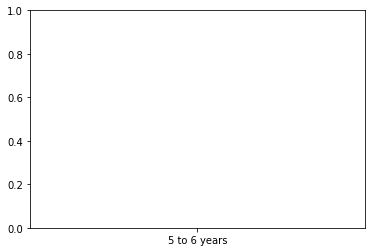

In [46]:
plt.plot(train.tenure_years_binned.unique(), [two_or_fewer_churn_rate, three_to_four_churn_rate, five_to_six_churn_rate])

In [ ]:
def calc_churn_rate(df):
    two_or_fewer = df[df.tenure_years_binned == "0 to 2 years"]
    three_to_four = df[df.tenure_years_binned == "3 to 4 years"]
    five_to_six = df[df.tenure_years_binned == "5 to 6 years"]
    
    (train.churn == "Yes").sum() / train.shape[0]